Number of fits files 8
(100, 256, 2048)
(200, 256, 2048)
(280, 256, 2048)


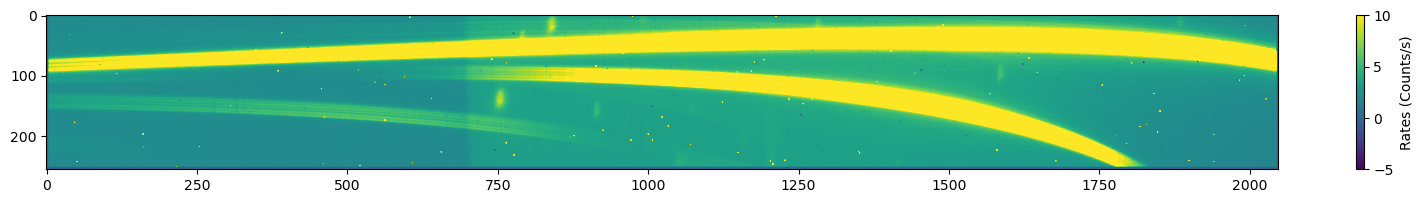

In [1]:
# Initializing the data and plotting the median of the images.

# Importing the necessary modules
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import numpy as np

# Folder containing all the fits files
folder ='./JWST/'

# Listing the rateints files
list = glob.glob(folder+"*/*rateints.fits")
print(f"Number of fits files {len(list)}")


#start, end = 4, len(list)-1 
initiate=True
# If some rateints files contain the full-frame image, they will have to be considered separately.
for l in range(4,len(list)-1):
    filename = list[l]

    with fits.open(filename) as hdulist:
        time = hdulist['INT_TIMES'].data

        if initiate:
            data_raw = hdulist['SCI'].data
            errors = hdulist['ERR'].data
            dq = hdulist['DQ'].data
            bjd = [time[a][-2]+2400000.5 for a in range(len(time))]
            initiate=False
        else:
            data_raw = np.append(data_raw, hdulist['SCI'].data, axis=0)
            errors = np.append(errors, hdulist['ERR'].data, axis=0)
            dq = np.append(dq, hdulist['DQ'].data, axis=0)

            bjd = np.append(
                bjd, [time[a][-2]+2400000.5 for a in range(len(time))])

        print(data_raw.shape)

median_image = np.median(data_raw, axis=0)

plt.figure(figsize=(20, 2))
im = plt.imshow(median_image)
im.set_clim(-5, 10)
cb = plt.colorbar()
cb.ax.set_ylabel('Rates (Counts/s)')
#plt.savefig("plots/plot1"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)

plt.show()


In [1]:
# To correct for bad pixels identified by DQ flags

import scipy.interpolate as interp

def dq_components(value, flags_to_ignore=None):
    """Returns the components of DQ flags from the total sum.
    In some cases, it may be necessary to not correct for some of the DQ flags.

    Args:
        value (int): DQ flag total value
        flags_to_ignore (dictionary of ints): The DQ flags which should be ignored. Defaults to None.

    Returns:
        np.array: List of DQ flags which are present in the pixel.
    """
    if flags_to_ignore is None:
        flags_to_ignore={}

    v = []

    # Converting the decimal number
    # into its binary equivalent.
    while (value > 0):
        v.append(int(value % 2))
        value = int(value / 2)


    exps = np.empty(0)
    for i in range(0, len(v)):
        if (v[i] == 1):
            ex1 = int(2**i)
            if ex1 not in flags_to_ignore:
                exps = np.append(exps, ex1)

    return exps

def neighbourhood_range(j,k):
    """Finds the 9x9 pixel neighbourhood of the faulty pixel.

    Args:

        j (int): y-coordinates of the faulty pixel
        k (int): x-coordinates of the faulty pixel

    Returns:
        int,int,int,int: The 9x9 pixel neighbourhood of the faulty pixel.
    """
    if j-4 < 0:
        xlim1,xlim2=0,9
    elif j+4 > 256:
        xlim1,xlim2=247,256
    else:
        xlim1,xlim2=j-4,j+4

    if k-4<4:
        ylim1,ylim2=4,13
    elif k+4>2044:
        ylim1,ylim2=2035,2044
    else:
        ylim1,ylim2=k-4,k+4
    
    return xlim1,xlim2,ylim1,ylim2

def find_median(data1,j,k):
    """Was using this function initially, but neighbourhood_range function should speed up the code.

    Finds the median value in the 9x9 pixel neighbourhood of the faulty pixel.

    Args:
        data1 (2-D array): Array showing values in one integration
        j (int): y-coordinates of the faulty pixel
        k (int): x-coordinates of the faulty pixel

    Returns:
        float: The median value which should be used to replace the pixel value.
    """
    if j-4 < 0:
        xlim1,xlim2=0,9
    elif j+4 > 256:
        xlim1,xlim2=247,256
    else:
        xlim1,xlim2=j-4,j+4

    if k-4<4:
        ylim1,ylim2=4,13
    elif k+4>2044:
        ylim1,ylim2=2035,2044
    else:
        ylim1,ylim2=k-4,k+4
    
    return np.median(data1[xlim1:xlim2,ylim1:ylim2])


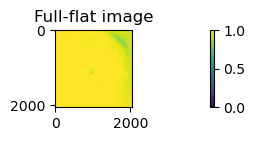

Average of the flat field image is 0.9988889827898089


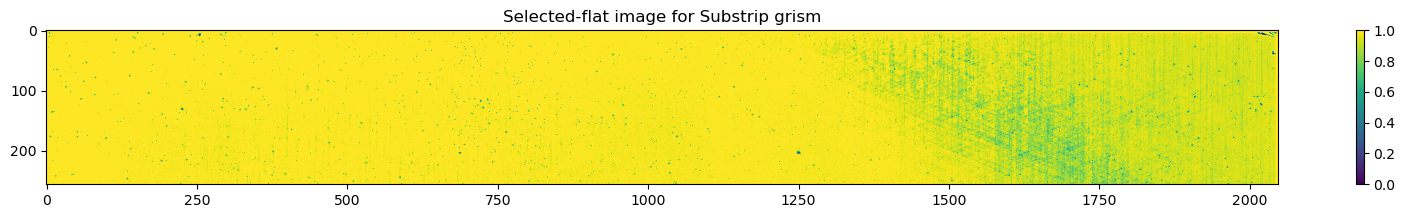

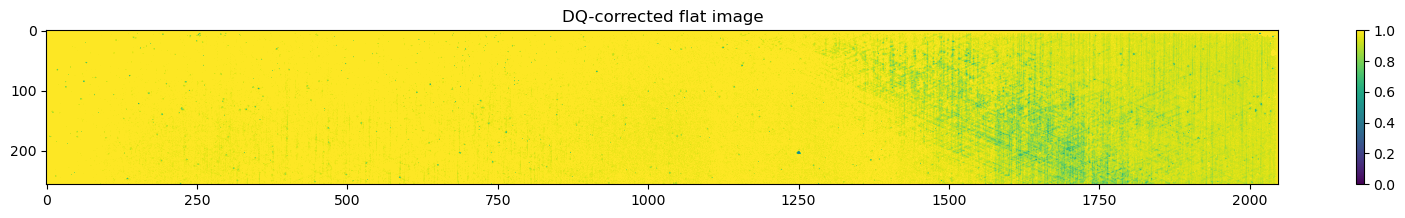

In [2]:
# Plot the flat field image, and correct it for DQ flags.
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import math

# Path to flat-field file
flat_field = './jwst_niriss_flat_0275.fits'

with fits.open(flat_field) as hdul:
    flat_data = hdul['SCI'].data
    dq_flat=hdul['DQ'].data
    flat_err = hdul['ERR'].data
    plt.figure(figsize=(20, 1))
    plt.title('Full-flat image')
    im = plt.imshow(flat_data)
    im.set_clim(0, 1)
    cb = plt.colorbar()
    plt.show()
    # The average should be 1.
    print(f"Average of the flat field image is {np.average(flat_data)}")

    plt.figure(figsize=(20, 2))
    plt.title('Selected-flat image for Substrip grism')
    im = plt.imshow(flat_data[:256, :])
    im.set_clim(0, 1)
    #https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-detector-overview/niriss-detector-readout
    cb = plt.colorbar()
    #plt.savefig("flat1"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)

    plt.show()

flat_data = flat_data[:256, :]
dq_flat = dq_flat[:256, :]
flat_err=flat_err[:256, :]

flat_corr = np.copy(flat_data)
flat_err_corr=np.copy(flat_err)
for j in range(256):
    for k in range(4, 2044):
        if math.isnan(flat_data[j,k]):
            flat_corr[j, k] = find_median(flat_data, j, k)
        else:
            #flags_dq = dq_components(dq_flat[j][k])
            #if len(flags_dq) == 0:
            #    continue
            if int(dq_flat[j][k])>0:
                xlim1,xlim2,ylim1,ylim2=neighbourhood_range(j,k)
            
                flat_corr[j, k] = np.median(flat_data[xlim1:xlim2,ylim1:ylim2])#flat_data, j, k)
                flat_err_corr[j, k] = np.median(flat_err[xlim1:xlim2,ylim1:ylim2])#flat_err, j, k)

plt.figure(figsize=(20, 2))
plt.title('DQ-corrected flat image')
im = plt.imshow(flat_corr)
im.set_clim(0, 1)
cb = plt.colorbar()
#plt.savefig("flat_median"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)

plt.show()

In [3]:
# This code uses multiple cores as high number of integrations makes it very slow otherwise.

import multiprocessing as mp
import copy

# Leaving out 1 cpu core to avoid the system getting frozen.
cpu = mp.cpu_count()-1

data_dq_corr = np.copy(data_raw)
data_flat_corr = np.copy(data_raw)

def dq_func(i):
    """This function handles the DQ flag correction in the image.

    Args:
        i (int): integration number of the image.

    Returns:
        DQ flag corrected image and error of the particular integration.
    """
    temp_e = np.copy(errors[i])
    data_dq_corr1= np.copy(data_raw[i])
    for j in range(256):
        for k in range(4, 2040):
            """flags_dq = dq_components(dq[i][j][k], flags_to_ignore={
                             4096})
            if len(flags_dq) == 0:
                continue"""
            if int(dq[i][j][k]) != 0 and int(dq[i][j][k])!=4096:
                xlim1,xlim2,ylim1,ylim2=neighbourhood_range(j,k)
                data_dq_corr1[j, k] = np.median(data_raw[i][xlim1:xlim2,ylim1:ylim2])
                temp_e[j,k] = np.median(errors[i][xlim1:xlim2,ylim1:ylim2])
    #print(i)
    return data_dq_corr1 , temp_e

error_dq_corr = np.empty(np.shape(errors))
if __name__ == "__main__":
    print(f"Running on {cpu} CPU cores now")

    inputs = [i for i in range(280)]
    pool = mp.Pool(processes=cpu)
    outputs = pool.map(dq_func, inputs)
    for k,o in enumerate(outputs):
        data_dq_corr[k]=o[0]
        error_dq_corr[k] = o[1]

Running on 7 CPU cores now


In [5]:
# Some pixels still had zero-errors, so we correct for those pixels again.
# This code uses multiple cores as high number of integrations makes it very slow otherwise.

import copy
import multiprocessing as mp
import copy

# Leaving out 1 cpu core to avoid the system getting frozen.
cpu = mp.cpu_count()-1
errors_array = copy.deepcopy(error_dq_corr)

def dq_func2(i):
    """This function handles the zero-noise correction in the image.

    Args:
        i (int): integration number of the image.

    Returns:
        Zero-noise corrected image and error of the particular integration.
    """
    temp_e = np.copy(errors_array[i])
    data_dq_corr1= np.copy(data_dq_corr[i])
    for j in range(256):
        for k in range(4, 2040):
            if errors_array[i, j,k] <= 0:
                xlim1,xlim2,ylim1,ylim2=neighbourhood_range(j,k)
                data_dq_corr1[j, k] = np.median(data_dq_corr[i][xlim1:xlim2,ylim1:ylim2])
                temp_e[j,k] = np.median(errors_array[i][xlim1:xlim2,ylim1:ylim2])
                #data_dq_corr1[j, k] = find_median(data_dq_corr[i], j, k)
                #temp_e[j,k] = find_median(errors_array[i], j, k)
    return data_dq_corr1 , temp_e


if __name__ == "__main__":
    print(f"Running on {cpu} CPU cores now")

    inputs = [i for i in range(280)]
    pool = mp.Pool(processes=cpu)
    outputs = pool.map(dq_func2, inputs)
    for k, o in enumerate(outputs):
        data_dq_corr[k]=o[0]
        error_dq_corr[k] = o[1]
        

Running on 7 CPU cores now


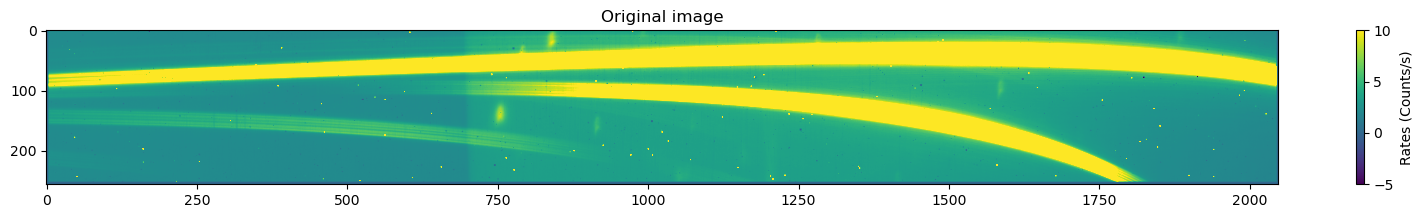

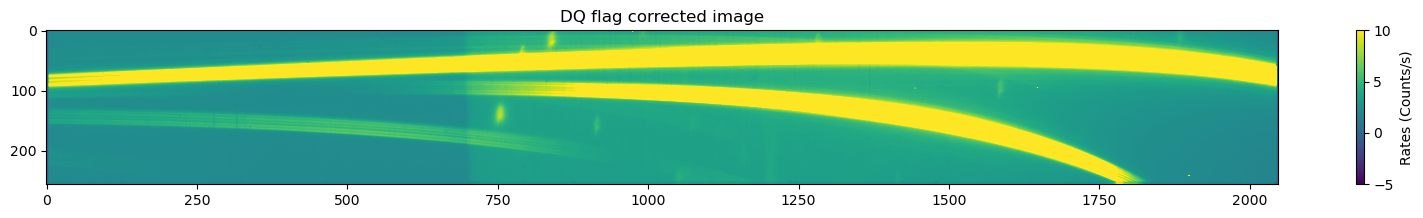

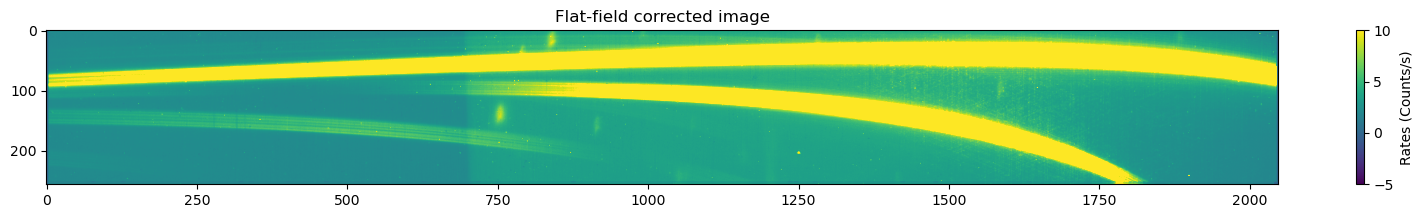

In [4]:
# The original raw image, DQ flag corrected image, and the flat-field corrected image.
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 2))
plt.title('Original image')

im = plt.imshow(np.median(data_raw, axis=0))
im.set_clim(-5, 10)
cb = plt.colorbar()
cb.ax.set_ylabel('Rates (Counts/s)')
#plt.savefig("plots/plot1"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)

plt.show()

plt.figure(figsize=(20, 2))
im = plt.imshow(np.median(data_dq_corr, axis=0))
plt.title('DQ flag corrected image')
im.set_clim(-5, 10)
cb = plt.colorbar()
cb.ax.set_ylabel('Rates (Counts/s)')
#plt.savefig("plots/plot1"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)

plt.show()

data_flat_corr = np.empty(data_dq_corr.shape)
errors_flat_corr = np.empty(data_dq_corr.shape)

for i in range(280):
    data_flat_corr[i] = data_dq_corr[i]/flat_corr
    errors_flat_corr[i] = np.sqrt(error_dq_corr[i]**2 + (flat_err_corr)**2)
    

plt.figure(figsize=(20, 2))
im = plt.imshow(np.median(data_flat_corr, axis=0))
plt.title('Flat-field corrected image')
im.set_clim(-5, 10)
cb = plt.colorbar()
cb.ax.set_ylabel('Rates (Counts/s)')
#plt.savefig("noise/data_interp_corrected"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)
plt.show()


In [7]:
# Functions to trace the spectrum and fit with chebychev polynomial.
# Taken from jdat_notebooks.
from scipy.ndimage import gaussian_filter1d
from numpy.polynomial import chebyshev


def trace_spectrum(image, xstart, ystart, profile_radius=30, gauss_filter_width=10, xend=None):
    """
    Function that non-parametrically traces NIRISS/SOSS spectra. First, to get the centroid at xstart and 
    ystart, it convolves the spatial profile with a gaussian filter, finding its peak through usual flux-weighted 
    centroiding. Next, this centroid is using to find the one left to it through the same algorithm. 
    
    Parameters
    ----------
    image: ndarray
        The image that wants to be traced.
    xstart: float
        The x-position (column) on which the tracing algorithm will be started
    ystart: float
        The estimated y-position (row) of the center of the trace. An estimate within 10-20 pixels is enough.
    profile_radius: float
        Expected radius of the profile measured from its center. Only this region will be used to estimate 
        the centroids of the spectrum.
    gauss_filter_width: float
        Width of the gaussian filter used to perform the centroiding of the first column
    xend: int
        x-position at which tracing ends. If none, trace all the columns left to xstart.
    """

    # Define x-axis:
    if xend is not None:
        x = np.arange(xend, xstart)
    else:
        x = np.arange(0, xstart)

    # Define y-axis:
    y = np.arange(image.shape[0])

    # Define array that will save centroids at each x:
    ycentroids = np.zeros(len(x))

    for i in range(len(x))[::-1]:
        xcurrent = x[i]

        # Convolve column with a gaussian filter; remove median before convolving:
        filtered_column = gaussian_filter1d(
            image[:, xcurrent] - np.median(image[:, xcurrent]), gauss_filter_width)

        # Find centroid within profile_radius pixels of the initial guess:
        idx = np.where(np.abs(y-ystart) < profile_radius)[0]
        ycentroids[i] = np.sum(y[idx]*filtered_column[idx]) / \
            np.sum(filtered_column[idx])
        #if ycentroids[i] in y:
        ystart = ycentroids[i]

    #if

    return x, ycentroids


def select_cheby_order(x, y, min_order, max_order):
    """
    This function selects (and returns) the optimal order of a Chebyshev polynomial using the BIC.
    
    Parameters
    ----------
    x: ndarray
        Array with the regressors
    y: ndarray
        Array with the data
    min_order: int
        Minimum order to try
    max_order: int
        Maximum order to try
    """
    orders = np.arange(min_order, max_order)
    bics = np.zeros(len(orders))

    # Fit only non-nans:
    idx = np.where(~np.isnan(y))[0]
    n = len(idx)

    for i in range(len(orders)):
        order = orders[i]
        coeffs = chebyshev.chebfit(x[idx], y[idx], deg=order)
        try:
            RSS = np.sum((y - chebyshev.chebval(x[idx], coeffs))**2)
        except ValueError:
            print(i, order, y.shape, x.shape, x[idx])
        bics[i] = n * np.log(RSS / n) + (order + 1) * np.log(n)
    idx = np.where(np.min(bics) == bics)[0]
    return orders[idx][0]


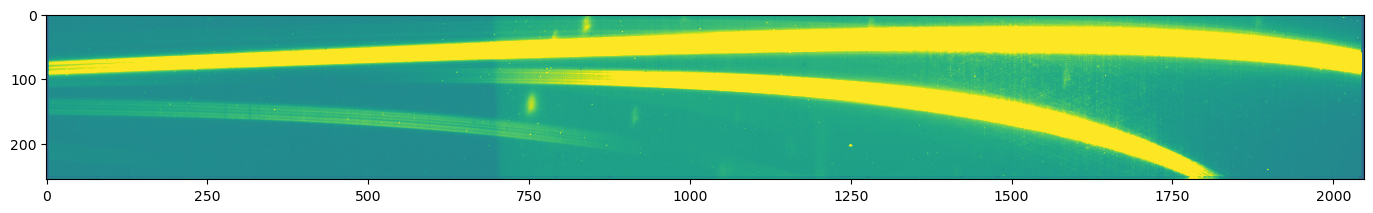

/home/p00471ap/anaconda3/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1670: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


Best order for Trace1:  14


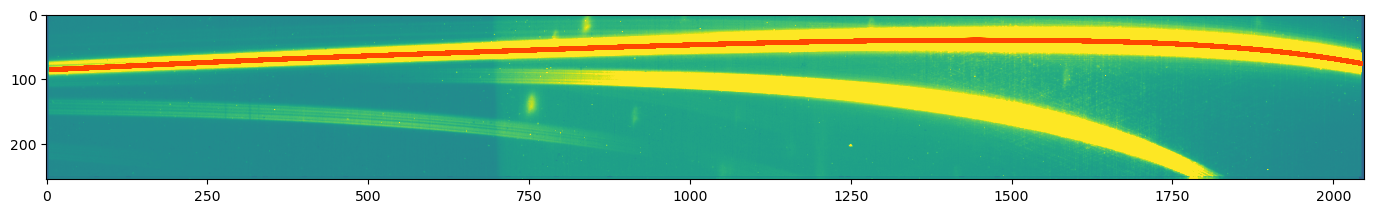

In [8]:
# Tracing order 1 spectra
data = data_flat_corr
median_image = np.median(data_flat_corr, axis=0)
# Define variables for the tracing algorithm:
nintegrations = data.shape[0]
# Choose the algorithm to start and end so we don't include reference pixels:
xstart = 2043
xend = 4
ystart = 70
aperture = 20

# Prepare arrays that will save our results:
X1 = np.zeros([nintegrations, xstart-xend])
Y1 = np.zeros([nintegrations, xstart-xend])

# Prepare median image plot, on top of which we'll show the traces:
plt.figure(figsize=(17, 12))
im = plt.imshow(median_image)  # *noise_masks)
im.set_clim(-5, 10)
plt.show()


# Iterate tracing through all integrations:
for i in range(280):  # nintegrations):
    X1[i, :], Y1[i, :] = trace_spectrum(
        data[i, :, :], xstart, ystart, xend=4)
    if max(Y1[i, :]) > 256:
        print(i, 'large')
    if min(Y1[i, :]) < 0:
        print(i, 'small')
    #plt.plot(X1[i, :], Y1[i, :], color='orangered', lw=3, alpha=0.1)


# Ignoring 4 pixels on each side of the long axis
x_lowlim = 4

# Try orders from 1 to 30 in the polynomial for all the traces:
orders = np.zeros(nintegrations)
for i in range(nintegrations):
    orders[i] = select_cheby_order(X1[i, x_lowlim:], Y1[i, x_lowlim:], 1, 30)

# Select best order:
order = int(np.median(orders))
print('Best order for Trace1: ', order)

# Use the best-one as deemed by the BIC to fit all the traces; plot them with median image on top:
plt.figure(figsize=(17, 12))
im = plt.imshow(median_image)
im.set_clim(-5, 10)
coeffs1 = np.zeros([nintegrations, order+1])
for i in range(nintegrations):
    # Fit only non-nans:
    idx = np.where(~np.isnan(Y1[i, x_lowlim:]))
    coeffs1[i, :] = chebyshev.chebfit(
        X1[i, x_lowlim:][idx], Y1[i, x_lowlim:][idx], deg=order)
    plt.plot(X1[i, x_lowlim:], chebyshev.chebval(
        X1[i, x_lowlim:], coeffs1[i, :]), color='orangered', lw=3)


trace_masks1 = np.ones(median_image.shape)
xs1, ys1 = X1[i, x_lowlim:], chebyshev.chebval(X1[i, x_lowlim:], coeffs1[i, :])

for i_x in range(len(xs1)):
    trace_masks1[int(ys1[i_x])-aperture:int(ys1[i_x])+aperture, int(xs1[i_x])] = np.zeros(
        trace_masks1[int(ys1[i_x])-aperture:int(ys1[i_x])+aperture, int(xs1[i_x])].shape)

#plt.savefig('noise/ord1'+".png", transparent=False,bbox_inches='tight', format='png', edgecolor='k', facecolor='w', dpi=300)


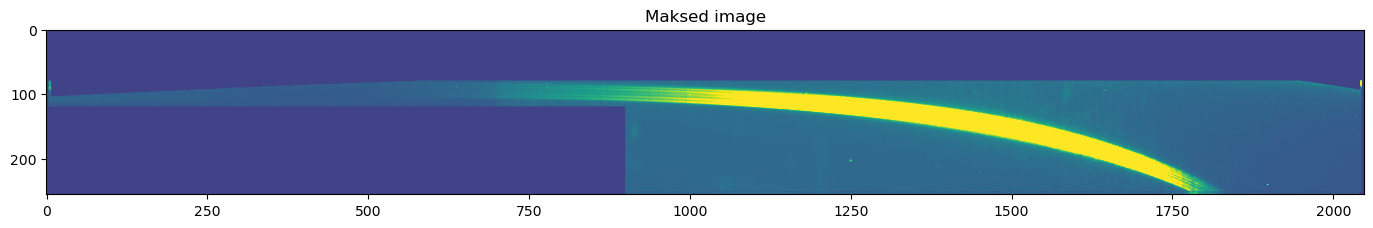

Best order for Trace2:  19


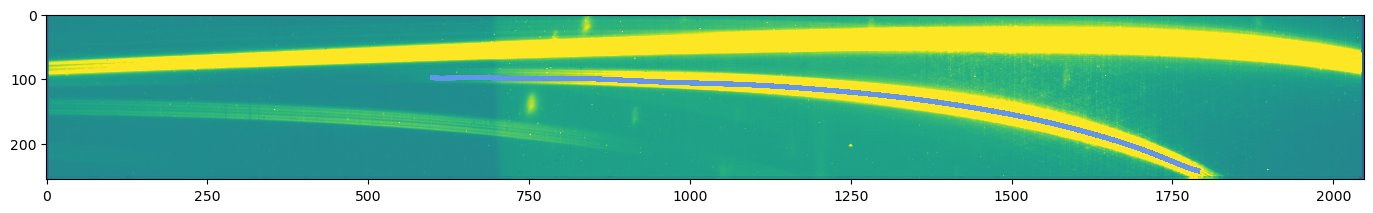

In [9]:
# Masking the trace of order1 spectra and tracing order 2 spectra

mask = np.zeros(median_image.shape)
mask[80:, :] = np.ones(mask[80:, :].shape)
mask[120:, :900] = np.zeros(mask[120:, :900].shape)
xstart = 1790  # 1839
ystart = 256
xend = 600  # 1000

plt.figure(figsize=(17, 12))
im = plt.imshow(median_image*mask*trace_masks1)
im.set_clim(-5, 20)
plt.title('Maksed image')
plt.show()

# Prepare arrays that will save our results for order 2:
X2 = np.zeros([nintegrations, xstart-xend])
Y2 = np.zeros([nintegrations, xstart-xend])

# Iterate tracing through all integrations:

for i in range(280):  # nintegrations):
    X2[i, :], Y2[i, :] = trace_spectrum(
        data[i, :, :]*mask*trace_masks1, xstart, ystart, xend=xend)
    #plt.plot(X2[i, :], Y2[i, :], color='cornflowerblue', lw=3, alpha=0.1)

# Try orders from 1 to 30 in the polynomial for all the traces:
orders = np.zeros(nintegrations)
for i in range(nintegrations):
    orders[i] = select_cheby_order(X2[i, :], Y2[i, :], 1, 30)

# Select best order:
order = int(np.median(orders))
print('Best order for Trace2: ', order)

plt.figure(figsize=(17, 12))
im = plt.imshow(median_image)
im.set_clim(-5, 10)
coeffs2 = np.zeros([nintegrations, order+1])
for i in range(nintegrations):
    # Fit only non-nans:
    idx = np.where(~np.isnan(Y2[i, :]))
    coeffs2[i, :] = chebyshev.chebfit(X2[i, :][idx], Y2[i, :][idx], deg=order)
    plt.plot(X2[i, :], chebyshev.chebval(
        X2[i, :], coeffs2[i, :]), color='cornflowerblue', lw=3)

xs1, ys1 = X2[i, :], chebyshev.chebval(X2[i, :], coeffs2[i, :])

trace_masks2 = np.ones(median_image.shape)
for i_x in range(len(xs1)):
    trace_masks2[int(ys1[i_x])-aperture:int(ys1[i_x])+aperture, int(xs1[i_x])] = np.zeros(
        trace_masks2[int(ys1[i_x])-aperture:int(ys1[i_x])+aperture, int(xs1[i_x])].shape)


plt.show()

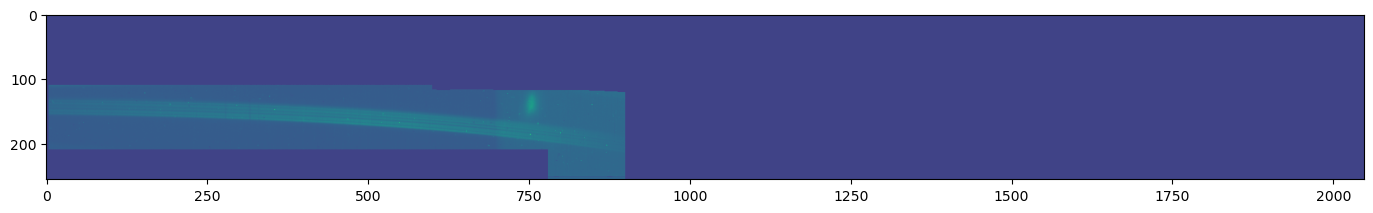

Best order for Trace3:  17


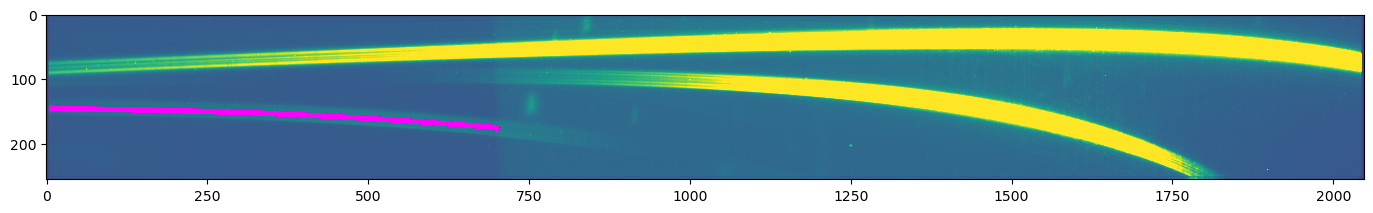

In [10]:
# Masking the trace of order3 spectra and tracing order 2 spectra

mask = np.zeros(median_image.shape)
mask[110:, :900] = np.ones(mask[110:, :900].shape)
mask[210:, :780] = np.zeros(mask[210:, :780].shape)
xstart = 700  # 1839
ystart = 180
xend = 4  # 1000

plt.figure(figsize=(17, 12))
im = plt.imshow(median_image*mask*trace_masks1*trace_masks2)
im.set_clim(-5, 20)

plt.show()


# Prepare arrays that will save our results for order 2:
X3 = np.zeros([nintegrations, xstart-xend])
Y3 = np.zeros([nintegrations, xstart-xend])

# Iterate tracing through all integrations:
for i in range(280):  # nintegrations):
    X3[i, :], Y3[i, :] = trace_spectrum(
        data[i, :, :]*mask*trace_masks1*trace_masks2, xstart, ystart, xend=xend)
    #plt.plot(X3[i, :], Y3[i, :], color='magenta', lw=3, alpha=0.1)


# Try orders from 1 to 30 in the polynomial for all the traces:
orders = np.zeros(nintegrations)
for i in range(nintegrations):
    orders[i] = select_cheby_order(X3[i,x_lowlim :], Y3[i,x_lowlim :], 1, 30)

# Select best order:
order = int(np.median(orders))
print('Best order for Trace3: ', order)
plt.figure(figsize=(17, 12))
im = plt.imshow(median_image)
im.set_clim(-5, 20)
coeffs3 = np.zeros([nintegrations, order+1])
for i in range(nintegrations):
    # Fit only non-nans:
    idx = np.where(~np.isnan(Y3[i, x_lowlim:]))
    coeffs3[i, :] = chebyshev.chebfit(
        X3[i, x_lowlim:][idx], Y3[i,x_lowlim :][idx], deg=order)
    plt.plot(X3[i,x_lowlim :], chebyshev.chebval(
        X3[i, x_lowlim:], coeffs3[i, :]), color='magenta', lw=3)
#plt.savefig("plots/plot3"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)

trace_masks3 = np.ones(median_image.shape)

xs1, ys1 = X3[i, :], chebyshev.chebval(X3[i, :], coeffs3[i, :])

for i_x in range(len(xs1)):
    trace_masks3[int(ys1[i_x])-aperture:int(ys1[i_x])+aperture, int(xs1[i_x])] = np.zeros(
        trace_masks3[int(ys1[i_x])-aperture:int(ys1[i_x])+aperture, int(xs1[i_x])].shape)



#plt.savefig("plots/plot2"+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)


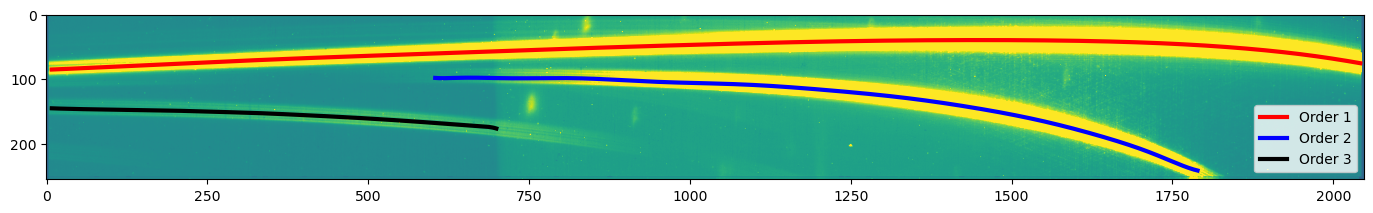

In [11]:
# Plotting all the traces
plt.figure(figsize=(17, 12))
im = plt.imshow(median_image)
im.set_clim(-5, 10)
for i in range(1):
    plt.plot(X1[i, x_lowlim:], chebyshev.chebval(
        X1[i, x_lowlim:], coeffs1[i, :]), color='red', label='Order 1', lw=3)
    plt.plot(X2[i, x_lowlim:], chebyshev.chebval(
        X2[i, x_lowlim:], coeffs2[i, :]), color='blue', label='Order 2', lw=3)
    plt.plot(X3[i, x_lowlim:], chebyshev.chebval(
        X3[i, x_lowlim:], coeffs3[i, :]), color='k', label='Order 3', lw=3)

plt.legend(loc='lower right')
#plt.savefig("data_traces"+".png", transparent=False,bbox_inches='tight', format='png', edgecolor='k', facecolor='w', dpi=300)
plt.show()


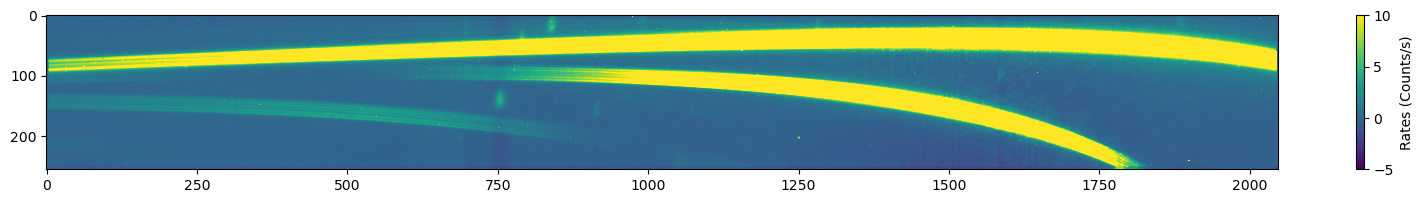

In [2]:
# Background and noise correction
# We will save the corrected data in a new array, as to keep track of the original dataset:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import chebyshev

corrected_data3 = np.copy(data_flat_corr)
radius = 20
nintegrations=280
for i in range(nintegrations):
    for j in range(data_flat_corr.shape[2]):
        
        # Create mask that will turn to zero values not to be used for background estimation:
        mask = np.ones(data_flat_corr.shape[1])
        
        if j in X1[i,:]:
            y1 = int(chebyshev.chebval(j, coeffs1[i,:]))
            mask[y1 - radius : y1 + radius] = 0.
            
        if j in X2[i,:]:
            y2 = int(chebyshev.chebval(j, coeffs2[i,:]))
            mask[y2 - radius : y2 + radius] = 0.
        
        if j in X3[i,:]:
            y3 = int(chebyshev.chebval(j, coeffs3[i,:]))
            mask[y3 - radius : y3 + radius] = 0.
            
        # Use only pixels that are not zero to calculate background through median:
        idx = np.where(mask != 0)[0]
        corrected_data3[i, :, j] = corrected_data3[i, :, j] - \
            np.median(corrected_data3[i, idx, j])


plt.figure(figsize=(20, 2))
im = plt.imshow(np.median(corrected_data3, axis=0))
im.set_clim(-5, 10)
cb = plt.colorbar()
cb.ax.set_ylabel('Rates (Counts/s)')

#plt.savefig("data_bkg_corrected"+".png", transparent=False, bbox_inches='tight', format='png', edgecolor='k', facecolor='w', dpi=300)
plt.show()


In [2]:
# Function for aperture extraction. Originally taken from jdat_notebooks, but parts of this have been modified.
def aperture_extraction(image, x, y, aperture_radius, background_radius=35, error_image=None, correct_bkg=True,median_image=None):
    """
    This function takes as inputs two arrays (x,y) that follow the trace, 
    and returns the added flux over the defined aperture radius (and its error, if an error image 
    is given as well), substracting in the way any background between the aperture radius and the 
    background radius. The background is calculated by taking the median of the points between the 
    aperture_radius and the background_radius.
    
    Parameters
    ----------
    image: ndarray
        Image from which the spectrum wants to be extracted
    x: ndarray
        Array with the x-axis of the trace (i.e., the columns, wavelength direction)
    y: ndarray
        Array with the y-axis of the trace (i.e., rows, spatial direction)
    aperture_radius: float
        Distance from the center of the trace at which you want to add fluxes.
    background_radius: float
        Distance from the center of the trace from which you want to calculate the background. The 
        background region will be between this radius and the aperture_radius.
    error_image: ndarray
        Image with the errors of each pixel value on the image ndarray above
    correct_bkg: boolean
        If True, apply background correction. If false, ommit this.
    """
    background_radius_lower=20
    
    #median_image=np.median(image)
    # Create array that will save our fluxes:
    flux = np.zeros(len(x))

    if error_image is not None:
        flux_error = np.zeros(len(x))

    max_column = image.shape[0]
    for i in range(len(x)):
        #l_variance,r_variance=0,0
        #l_fraction,r_fraction=0,0
        # Cut the column with which we'll be working with:
        column = image[:, int(x[i])]
        if error_image is not None:
            variance_column = error_image[:, int(x[i])]**2

        # Define limits given by the aperture_radius and background_radius variables:
        if correct_bkg:
            left_side_bkg = np.max([y[i] - background_radius, 0])
            right_side_bkg = np.min([max_column, y[i] + background_radius])
        left_side_ap = np.max([y[i] - aperture_radius, 0])
        right_side_ap = np.min([max_column, y[i] + aperture_radius])

        # Extract background, being careful with edges:
        if correct_bkg:
            bkg_left = column[np.max([0, int(left_side_bkg)]): np.max(
                [0, int(left_side_ap)])]
            bkg_right = column[np.min([int(right_side_ap), max_column]): np.max(
                [int(right_side_bkg), max_column])]
            bkg = np.median(np.append(bkg_left, bkg_right))
        else:
            bkg = 0.

        # Substract it from the column:
        column -= bkg

        # Perform aperture extraction of the background-substracted column, being careful with pixelization
        # at the edges. First, deal with left side:
        l_decimal, l_integer = np.modf(left_side_ap)
        l_integer = int(l_integer)
        if l_decimal < 0.5:
            l_fraction = (0.5 - l_decimal) * column[l_integer]
            #if l_integer < len(column):
            l_limit = np.min([max_column, l_integer + 1])
            if error_image is not None:
                l_fraction_variance = (
                    (0.5 - l_decimal)**2) * variance_column[l_integer]
                l_variance=variance_column[l_integer]
        else:
            l_fraction = (1. - (l_decimal - 0.5)) * column[l_integer + 1]
            #if l_integer < len(column)-1:
            l_limit = np.min([max_column, l_integer + 2])
            if error_image is not None:
                l_fraction_variance = (
                    (1. - (l_decimal - 0.5))**2) * variance_column[l_integer + 1]
                l_variance=variance_column[l_integer + 1]

        # Now right side:
        r_decimal, r_integer = np.modf(right_side_ap)
        r_integer = np.min([max_column-1,int(r_integer)])
        if r_decimal < 0.5:
            r_fraction = (1. - (0.5 - r_decimal)) * column[r_integer]
            r_limit = r_integer
            if error_image is not None:
                r_fraction_variance = (
                    (1. - (0.5 - r_decimal))**2) * variance_column[r_integer]
                r_variance=variance_column[r_integer]
        else:
            if r_integer < len(column)-1:
                r_fraction = (r_decimal - 0.5) * column[r_integer + 1]
                r_limit = np.min([max_column,r_integer + 1])
                if error_image is not None:
                    r_fraction_variance = (
                        (r_decimal - 0.5)**2) * variance_column[r_integer + 1]
                    r_variance=variance_column[r_integer + 1]

        # Save total flux in current column:
        flux_vals=np.array([l_fraction,r_fraction,*column[l_limit:r_limit]],dtype=float)
        flux_weights = np.array(
            [l_variance, r_variance, *variance_column[l_limit:r_limit]], dtype=float)
        #if 0 in flux_weights:
        #_len=np.where(flux_weights <= 0)
        #if len(_len)!=0:
        #    print(_len)
        idxs=np.where(flux_weights != 0)
        #flux_weights[np.where(flux_weights != 0)]
        #    #flux_weights[flux_weights.index(0)]=np.median(np.array(flux_weights,dtype=float))
                
        # Taking the weighted sum of flux_values.
        
        flux[i] = np.sum(flux_vals[idxs])#, weights=1/flux_weights[idxs])
        #flux[i] = l_fraction + r_fraction + np.sum(column[l_limit:r_limit])
        flux_weights[0],flux_weights[1]=r_fraction_variance,r_fraction_variance
        #if 0 in flux_weights:
        #    print(np.where(flux_weights == 0))
        if error_image is not None:
            # For the flux error, ommit edge values (contribution to total variance is small nonetheless):
            #flux_error[i] = np.sqrt(np.sum(variance_column[l_limit:r_limit]) + l_fraction_variance +r_fraction_variance)
            flux_error[i]=np.sqrt(np.sum(flux_weights[idxs]))
            #flux_error[i]=np.sqrt(1/np.sum(1/flux_weights[idxs]))

    if error_image is not None:
        return flux, flux_error
    else:
        return flux


In [3]:
# Extracting lightcurves from the three orders
from numpy.polynomial import chebyshev

data = corrected_data3
nintegrations = data.shape[0]
# Extraction parameters:
extraction_aperture = 15  # 30
background_aperture = 30

# Create dictionary:
spectra = {}
# Generate sub-dictionaries for each order:
spectra['order1'], spectra['order2'], spectra['order3'] = {}, {}, {}
# Save the X positions for both orders. X positions are the same for all integrations, so
# we save the ones corresponding to the first integration:
spectra['order1']['x'], spectra['order2']['x'], spectra['order3']['x'] = X1[0, :], X2[0, :], X3[0, :]
# Create sub-dictionaries that will save the fluxes and the errors on those fluxes:
spectra['order1']['flux'], spectra['order2']['flux'], spectra['order3']['flux'] = np.zeros([data.shape[0], len(X1[0, :])]),\
    np.zeros([data.shape[0], len(X2[0, :])]), np.zeros(
        [data.shape[0], len(X3[0, :])])

spectra['order1']['flux_errors'], spectra['order2']['flux_errors'], spectra['order3']['flux_errors'] = np.zeros([data.shape[0], len(X1[0, :])]),\
    np.zeros([data.shape[0], len(X2[0, :])]),np.zeros([data.shape[0], len(X3[0, :])])

# Now iterate through all integrations:
for i in range(nintegrations):
    # Trace order 1:
    y1 = chebyshev.chebval(X1[0, :], coeffs1[i, :])
    # Extract order 1:
    spectra['order1']['flux'][i, :], spectra['order1']['flux_errors'][i, :] = \
        aperture_extraction(data[i, :, :], X1[0, :], y1,
                            extraction_aperture,
                            error_image=errors_flat_corr[i, :, :],
                            correct_bkg=True)#,median_image)
    # Same for Order 2:
    y2 = chebyshev.chebval(X2[0, :], coeffs2[i, :])
    spectra['order2']['flux'][i, :], spectra['order2']['flux_errors'][i, :] = \
        aperture_extraction(data[i, :, :], X2[0, :], y2,
                            extraction_aperture,
                            error_image=errors_flat_corr[i, :, :],
                            correct_bkg=True)#,median_image)
    
    # Same for Order 3:
    y3 = chebyshev.chebval(X3[0, :], coeffs3[i, :])
    spectra['order3']['flux'][i, :], spectra['order3']['flux_errors'][i, :] = \
        aperture_extraction(data[i, :, :], X3[0, :], y3,
                            extraction_aperture,
                            error_image=errors_flat_corr[i, :, :],
                            correct_bkg=True)#,medianmedian_image)


46.5 ppm, 91.5 ppm, 703.9 ppm


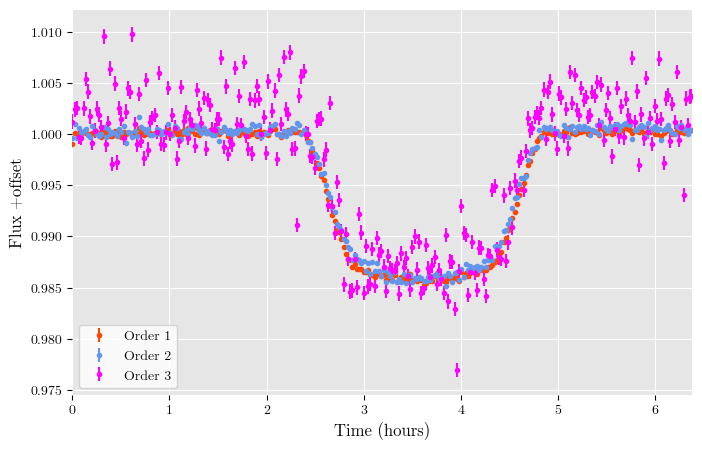

In [7]:
# Plotting white light curves for all three orders
import matplotlib.pyplot as plt
spectra['times'] = bjd  # hdul['INT_TIMES'].data['int_mid_BJD_TDB']

# Extract order 1 length, create array that will save white-light lightcurve (and errors):
NT1 = spectra['order1']['flux'].shape[0]
lc_order1 = np.zeros(NT1)
lc_errors_order1 = np.zeros(NT1)

# Same for order 2:
NT2 = spectra['order2']['flux'].shape[0]
lc_order2 = np.zeros(NT2)
lc_errors_order2 = np.zeros(NT2)

# Same for order 3:
NT3 = spectra['order3']['flux'].shape[0]
lc_order3 = np.zeros(NT3)
lc_errors_order3 = np.zeros(NT3)

# Indexes of uncontaminated spectra for Order 1 and 2:
idx_uncontaminated1 = np.where(spectra['order1']['x'] > 0)[0]
idx_uncontaminated2 = np.where(spectra['order2']['x'] > 0)[0]
idx_uncontaminated3 = np.where(spectra['order3']['x'] > 0)[0]

# Sum the fluxes and errors for each order. First, order 1:
for i in range(NT1):
    lc_order1[i] = np.sum(spectra['order1']['flux'][i, idx_uncontaminated1])
    lc_errors_order1[i] = np.sqrt(np.sum(spectra['order1']['flux_errors'][i, idx_uncontaminated1]**2))
    #lc_order1[i] = np.average(spectra['order1']['flux'][i, idx_uncontaminated1], weights=1/(spectra['order1']['flux_errors'][i, idx_uncontaminated1]**2))
    #lc_errors_order1[i] = 1/np.sqrt(np.sum(1/(spectra['order1']['flux_errors'][i, idx_uncontaminated1]**2)))

# Now order 2:
for i in range(NT2):
    lc_order2[i] = np.sum(spectra['order2']['flux'][i, idx_uncontaminated2])
    lc_errors_order2[i] = np.sqrt(np.sum(spectra['order2']['flux_errors'][i, idx_uncontaminated2]**2))
    #lc_order2[i] = np.average(spectra['order2']['flux'][i, idx_uncontaminated2], weights=1/(spectra['order2']['flux_errors'][i, idx_uncontaminated2]**2))
    #lc_errors_order2[i] = 1/np.sqrt(np.sum(1/(spectra['order2']['flux_errors'][i, idx_uncontaminated2]**2)))

for i in range(NT3):
    lc_order3[i] = np.sum(spectra['order3']['flux'][i, idx_uncontaminated3])
    lc_errors_order3[i] = np.sqrt(np.sum(spectra['order3']['flux_errors'][i, idx_uncontaminated3]**2))
    #lc_order3[i] = np.average(spectra['order3']['flux'][i, idx_uncontaminated3], weights=1/(spectra['order3']['flux_errors'][i, idx_uncontaminated3]**2))
    #lc_errors_order3[i] = 1/np.sqrt(np.sum(1/(spectra['order3']['flux_errors'][i, idx_uncontaminated3]**2)))

# Save median-normalized lightcurves and errors:
median_lc1, median_lc2, median_lc3 = np.median(lc_order1), np.median(lc_order2), np.median(lc_order3)
spectra['order1']['white-light'] = lc_order1 / median_lc1
spectra['order1']['white-light_errors'] = lc_errors_order1 / median_lc1
spectra['order2']['white-light'] = lc_order2 / median_lc2
spectra['order2']['white-light_errors'] = lc_errors_order2 / median_lc2
spectra['order3']['white-light'] = lc_order3 / median_lc3
spectra['order3']['white-light_errors'] = lc_errors_order3 / median_lc3
# Write median errors in ppm:
med_err_order1 = np.median(spectra['order1']['white-light_errors'])*1e6
med_err_order2 = np.median(spectra['order2']['white-light_errors'])*1e6
med_err_order3 = np.median(spectra['order3']['white-light_errors'])*1e6

# Save variable with times in units of hours since beggining of observation:
thours = (spectra['times'] - spectra['times'][0]) * 24

# Plot lightcurve
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['font.weight'] = 'bold'

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# Opacity of the lines in the plot [0,1]
alpha_val = 0.3
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('#E6E6E6')  # edgecolor='#E6E6E6', color='#EE6666'
ax.grid(alpha=1, linestyle='solid', color='w')
ax.set_axisbelow(True)
# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)
#ax.set_title('White-light lightcurve of HAT-P-1b NIRISS/SOSS observations')

ax.errorbar(thours, spectra['order1']['white-light'],
            yerr=spectra['order1']['white-light_errors'],
            color='orangered',
            fmt='.',
            label=f'Order 1')# ($\sigma={round(med_err_order1, 1)}$ ppm)')

ax.errorbar(thours, spectra['order2']['white-light'],
            yerr=spectra['order2']['white-light_errors'],
            color='cornflowerblue',
            fmt='.',
            label=f'Order 2')# ($\sigma={round(med_err_order2, 1)}$ ppm)')

ax.errorbar(thours, spectra['order3']['white-light'],
            yerr=spectra['order3']['white-light_errors'],
            color='magenta',
            fmt='.',
            label=f'Order 3')  # ($\sigma={round(med_err_order3, 1)}$ ppm)')

print(f"{round(np.median(spectra['order1']['white-light_errors'])*1e6, 1)} ppm, {round(np.median(spectra['order2']['white-light_errors'])*1e6, 1)} ppm, {round(np.median(spectra['order3']['white-light_errors'])*1e6, 1)} ppm")

# Define legend, limits, labels:
ax.legend()
ax.set_xlim(np.min(thours), np.max(thours))
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flux +offset')

#plt.savefig('lightcurve_orders_bkg_1'+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)
plt.show()
plt.close()

In [ ]:
# Errors in white light curves when we took inverse variance weighting
# 77.0 ppm, 164.0 ppm, 720.1 ppm

# Median of errors in 1nm wavelength bins.
#2903.1034846356943, 2764.1877319900664, 9573.426391143457


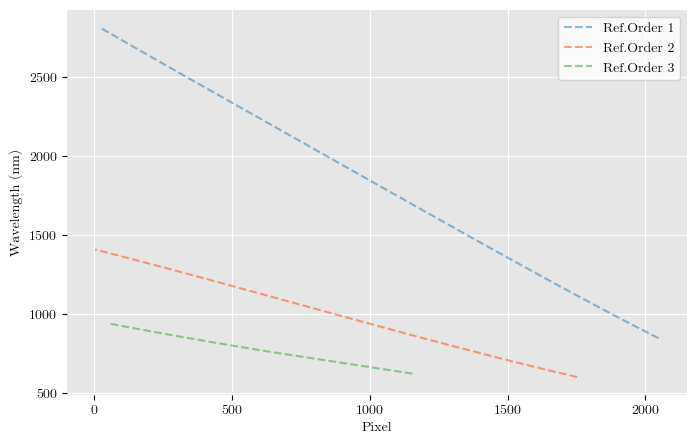

In [9]:
# Plotting the column-to-wavelength relation 
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits

# Path to the spectrace file
ref_file = './jwst_niriss_spectrace_0023.fits'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['font.weight'] = 'bold'

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# Opacity of the lines in the plot [0,1]
alpha_val = 0.3
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('#E6E6E6')  # edgecolor='#E6E6E6', color='#EE6666'
ax.grid(alpha=1, linestyle='solid', color='w')
ax.set_axisbelow(True)
# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)
    
colors=['tab:blue','orangered','tab:green']    
# http://jwst.astro.umontreal.ca/?page_id=51

#1st Order: 0.974 nm/pixel	830 nm	2816 nm
#2nd Order: 0.467 nm/pixel	600 nm*	1409 nm
#3rd Order: 0.3 nm/pixel	600 nm*	~940 nm

# Simulator Guide at http://maestria.astro.umontreal.ca/niriss/simu1D/simu1D.php suggests different rates. 
# Loic Albert "SOSS Simulator Guide"

rate1, low1, high1 = 0.974, 830, 2816
rate2, low2, high2 = 0.467,	600, 1409
rate3, low3, high3 = 0.3, 600, 940

low=[low1,low2,low3]
high=[high1,high2,high3]

w1,x1,y1,t1=np.empty(0),np.empty(0),np.empty(0),np.empty(0)
w2,x2,y2,t2=np.empty(0),np.empty(0),np.empty(0),np.empty(0)
w3,x3,y3,t3=np.empty(0),np.empty(0),np.empty(0),np.empty(0)

ws=[w1,w2,w3]
xs=[x1,x2,x3]
ys=[y1,y2,y3]
ts=[t1,t2,t3]
#tilt=[t1,t2,t3]




ymax, xmax = 256, 2048
with fits.open(ref_file) as hdulist:
    for order in range(3):

        #for order in range(1,4):
        #print(order)
        data_ref = hdulist[order+1].data

        for i in range((data_ref.shape)[0]):
            wlen, x, y, t = data_ref[i][0]*1e3, data_ref[i][1], data_ref[i][2], data_ref[i][3]
            if wlen >= low[order] and wlen <= high[order]:
                if x >= 0 and x <= xmax:
                    if y >= 0 and y <= ymax:
                        xs[order] = np.append(xs[order], x)
                        ys[order] = np.append(ys[order], y)
                        ts[order] = np.append(ts[order], t)
                        ws[order] = np.append(ws[order], wlen)

        plt.plot(xs[order], ws[order], alpha=0.5, linestyle='dashed',color=colors[order],label='Ref.Order '+str(order+1))



outname = 'test'
xlabel = 'Pixel'
#xlims=[5,23]
ylabel = 'Wavelength (nm)'

ax.set_xlabel(xlabel, fontsize=10, fontweight='bold')
ax.set_ylabel(ylabel, fontsize=10, fontweight='bold')
plt.legend(loc='best')
#plt.savefig('pix_to_wave'+".png", transparent=False, bbox_inches='tight',format='png', edgecolor='k', facecolor='w', dpi=300)
plt.show()
plt.close()


In [10]:
# Interpolating the relation to get wavelength for  individual columns
from scipy import interpolate

rate1, low1, high1 = 0.974, 830, 2816
rate2, low2, high2 = 0.467,	600, 1409
rate3, low3, high3 = 0.3, 600, 940
low = [low1, low2, low3]
high = [high1, high2, high3]

orders = ['order1', 'order2', 'order3']

for ord in range(3):

    cs = interpolate.CubicSpline(np.flip(xs[ord]), np.flip(ws[ord]))
    ws_new = np.empty(0)
    for i in spectra[orders[ord]]['x']:
        ws_new = np.append(ws_new, cs(i))

    spectra[orders[ord]]['w'] = ws_new

In [ ]:
# Details related to the filter response file

# http://jwst.astro.umontreal.ca/?page_id=51
# gr700xd_throughput.csv
# NIRISS Instrument Team Estimated Throughput. Source: Loic Albert.
# First order is valid between 0.6 and 3.0 microns.
# Second order is valid between 0.6 and 1.4 microns.
# Third order is a highly uncertain guess lacking lab test.

In [16]:
# Create wlen dependent lightcurves
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from scipy import interpolate

# Wavelength range for binning.
step = 25

# Folder containing files which has lambda transmission data for JWST
pathadd='./'

# Number of filters to generate in one folder. 
# In some cases, I found that it was difficult to run TransitFit for 
# more than 200 lightcurves in a single run. 
filter_limit = 200


rate1, low1, high1 = 0.974, 850, 2800#0.974, 830, 2816
# Although upper limit of wavelength in order 2 is 1409, 
# we are excluding the verlapping regions from Order 1, as the 
# order 1 lightcurves have smaller error values.
rate2, low2, high2 = 0.467,	600, 850#1409 
rate3, low3, high3 = 0.3, 600, 940
low = [low1, low2, low3]
high = [high1, high2, high3]

orders = ['order1', 'order2', 'order3']

# The files will be saved in this folder
parent_folder = './'+str(step)+'nm/'
path = Path(parent_folder)
path.mkdir(parents=True, exist_ok=True)


run = 0
branch = 0

input_file = open(parent_folder+'input_'+str(branch) +
                  '_'+str(step)+'nm.csv', 'w')
input_file.write('Path,Telescope,Filter,Epochs,Detrending\n')

filter_file = open(parent_folder+'filter_'+str(branch) +
                   '_'+str(step)+'nm.csv', 'w')
filter_file.write(f"filter_idx,low_wl,high_wl\n")


for o in range(1, -1, -1):
    order = orders[o]
    print(f"Working for {order}")

    filter_folder = './filters_'+str(branch)+order+'_'+str(step)+'nm'
    lc_folder = './lcs_'+str(branch)+order+'_'+str(step)+'nm'

    path = Path(parent_folder+filter_folder)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(parent_folder+lc_folder)
    path.mkdir(parents=True, exist_ok=True)

    waveln = spectra[order]['w']  # [indices[o]]
    spectra_temp = spectra[order]['flux']  # [:,indices[o]]
    spectra_err = spectra[order]['flux_errors']  # [:,indices[o]]

    df = pd.read_csv(pathadd+'order'+str(o+1)+'_ref-file.csv')

    for w in range(low[o], high[o], step):

        index = [i for i, v in enumerate(
            waveln) if v >= w-0.5 and v < w+step-0.5]

        if len(index) == 0:
            continue
        df1 = df.loc[(df['# Wavelength (nm)'] >= w-0.5) &
                     (df['# Wavelength (nm)'] < w+step-0.5)]

        if len(df1) < 4:
            continue
        filename_lc = lc_folder+'/'+order+'_'+str(w)+'nm.csv'
        filter = filter_folder+'/'+order+'_'+str(w)+'nm.csv'

        df1.to_csv(parent_folder+filter, columns=['# Wavelength (nm)', ' lambda Transmission'], header=[
                   '# Wavelength (nm)', ' lambda Transmission'], index=False)

        input_file.write(f"{filename_lc},0,{run},3,0\n")
        filter_file.write(f"{run},{filter},\n")

        with open(parent_folder+filename_lc, 'w') as f:
            f.write('Time,Flux,Flux_err\n')
            for i_time in range(280):
                f.write(f"{spectra['times'][i_time]},{np.average(spectra_temp[i_time, index],weights=1/(spectra_err[i_time, index]**2))}, {np.sqrt(1/np.sum(1/np.power(spectra_err[i_time, index],2)))}\n")

        run += 1
        if run == filter_limit:
            run = 0
            branch += 1
            input_file.close()
            filter_file.close()
            input_file = open(parent_folder+'input_' +
                              str(branch)+'_'+str(step)+'nm.csv', 'w')
            input_file.write('Path,Telescope,Filter,Epochs,Detrending\n')

            filter_file = open(parent_folder+'filter_' +
                               str(branch)+'_'+str(step)+'nm.csv', 'w')
            filter_file.write(f"filter_idx,low_wl,high_wl\n")

            filter_folder = './filters_'+str(branch)+order+'_'+str(step)+'nm'
            lc_folder = './lcs_'+str(branch)+order+'_'+str(step)+'nm'

            path = Path(parent_folder+filter_folder)
            path.mkdir(parents=True, exist_ok=True)
            path = Path(parent_folder+lc_folder)
            path.mkdir(parents=True, exist_ok=True)


input_file.close()
filter_file.close()

print(f'All files saved in {parent_folder}')

Working for order2
Working for order1
All files saved in ./25nm/


In [22]:
# Normalise and correct the lightcurves by removing outliers (>6sigma).
# Clipping of outliers may not be required in all cases.
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
limit=6
inputpath = './25nm/input_0_25nm.csv'

df = pd.read_csv(inputpath)
pathadd='./25nm'

for i in range(len(df)):
    if df['Telescope'][i]==0:
        lc=pd.read_csv(pathadd+df['Path'][i][1:])
        flux=lc['Flux'].to_numpy()
        median=np.median(lc['Flux'])
        sd=np.std(lc['Flux'])

        indices=[f for f,_ in enumerate(flux) if _<median+limit*sd and _>median-limit*sd]
        if len(indices)!=len(flux):print("Removed")
        #else: print("Done")
        lc['Time'], lc['Flux'], lc['Flux_err'] = lc['Time'][indices], lc['Flux'][indices] / \
            np.median(lc['Flux'][indices]), lc['Flux_err'][indices] / \
            np.median(lc['Flux'][indices])


        filepath1 = Path(os.path.dirname(pathadd+'/corrected'+df['Path'][i][1:]))
        filepath1.mkdir(parents=True, exist_ok=True)

        lc.to_csv(pathadd+'/corrected'+df['Path'][i][1:], columns=['Time', 'Flux', 'Flux_err'], header=['Time', 'Flux', 'Flux_err'], index=False)
        #plt.errorbar(lc['Time'], lc['Flux'],lc['Flux_err'],linestyle='',marker='o')
        #plt.show()

print(f"All files saved in {pathadd+'/corrected/'}")


All files saved in ./25nm/corrected/
